In [1]:
import numpy as np
from atom import *

读取XDATCAR文件，步长为2fs

In [2]:
LiF = loadfile(2)

Reading XDATCAR...
F      : 32
Li     : 30
Loading XDATCAR...
done


制作测试集

In [4]:
train_data = np.array([np.array(np.append(LiF["F"].position[i],LiF["Li"].position[i])) for i in range(len(LiF["F"].position))])
train_data

array([[ 0.00000000e+00,  7.50000000e-01,  4.99389640e-01, ...,
         0.00000000e+00,  9.99874490e-01,  9.99874490e-01],
       [ 4.28360000e-04,  7.48998450e-01,  4.99849100e-01, ...,
         1.22934000e-03,  1.00393532e+00,  9.92175290e-01],
       [ 8.56410000e-04,  7.47995110e-01,  5.00294510e-01, ...,
         2.39904000e-03,  1.00791136e+00,  9.84599770e-01],
       ...,
       [ 3.89643000e-03,  6.90992870e-01,  5.49318560e-01, ...,
        -2.16890390e-01,  7.58070110e-01,  1.50656901e+00],
       [ 5.31916000e-03,  6.91959410e-01,  5.45704180e-01, ...,
        -2.16468880e-01,  7.58178410e-01,  1.50983454e+00],
       [ 6.74412000e-03,  6.93024520e-01,  5.41928810e-01, ...,
        -2.16301130e-01,  7.58276970e-01,  1.51328590e+00]])

In [5]:
import torch
import torch.nn as nn
import numpy as np

用前五帧的路径去预测第六帧

In [6]:
fwd = 5

class MyDNN(nn.Module):
    def __init__(self):
        super(MyDNN, self).__init__()
        self.layer1 = nn.Linear(62*3*fwd, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 62*3)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [9]:
# Create a MyDNN instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyDNN().to(device)

num_epochs = 1000

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

loss_array = []   #draw picture

# Train the model
for epoch in range(num_epochs):
    # Get the input and target arrays
    
    input_array = torch.from_numpy(train_data[epoch:epoch+fwd].reshape(-1)).float().to(device)
    target_array = torch.from_numpy(train_data[epoch+fwd+1].reshape(-1)).float().to(device)

    # Forward pass
    output_array = model(input_array)

    # Compute the loss
    loss = criterion(output_array, target_array)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.9f}'.format(epoch+1, num_epochs, loss.item()))
        loss_array.append(loss.item())

Epoch [10/1000], Loss: 0.207619742
Epoch [20/1000], Loss: 0.083796710
Epoch [30/1000], Loss: 0.024766896
Epoch [40/1000], Loss: 0.006487397
Epoch [50/1000], Loss: 0.001603657
Epoch [60/1000], Loss: 0.000920533
Epoch [70/1000], Loss: 0.000745497
Epoch [80/1000], Loss: 0.000389359
Epoch [90/1000], Loss: 0.000399211
Epoch [100/1000], Loss: 0.000328869
Epoch [110/1000], Loss: 0.000350409
Epoch [120/1000], Loss: 0.000330071
Epoch [130/1000], Loss: 0.000356985
Epoch [140/1000], Loss: 0.000391981
Epoch [150/1000], Loss: 0.000340489
Epoch [160/1000], Loss: 0.000316033
Epoch [170/1000], Loss: 0.000351933
Epoch [180/1000], Loss: 0.000298705
Epoch [190/1000], Loss: 0.000331718
Epoch [200/1000], Loss: 0.000404278
Epoch [210/1000], Loss: 0.000297820
Epoch [220/1000], Loss: 0.000266340
Epoch [230/1000], Loss: 0.000307388
Epoch [240/1000], Loss: 0.000303485
Epoch [250/1000], Loss: 0.000277667
Epoch [260/1000], Loss: 0.000273229
Epoch [270/1000], Loss: 0.000360393
Epoch [280/1000], Loss: 0.000242327
E

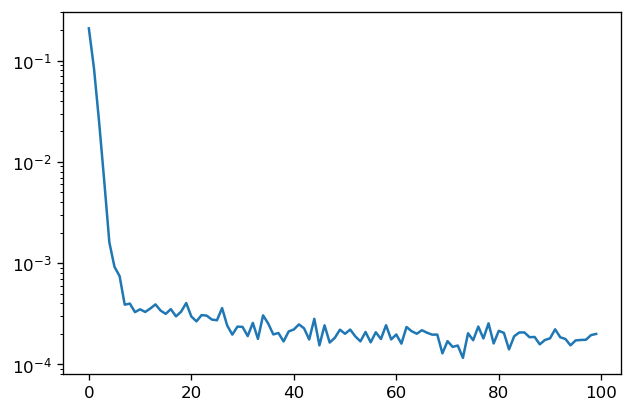

In [11]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")

用frame的前五帧预测下一帧

In [13]:
# Get the input array for prediction
frame = 100
input_array = torch.from_numpy(train_data[frame-5:frame].reshape(-1)).float().to(device)

# Predict the output array
with torch.no_grad():
    output_array = model(input_array)

# Convert the output tensor to a numpy array
output_array = output_array.cpu().numpy()

In [12]:
#print(output_array.reshape(-1,3))

In [15]:
import ase
from ase.io import read ,write
from ase.build import sort
from ase.visualize import view

# 将某一帧写出

In [17]:
with open('LiF.vasp', 'w') as f:
    f.write("vasp\n")
    f.write("1.0\n")
    for i in (LiF["F"].lattice):
        f.write(str(i)[1:-1]+"\n")
    for (i,j) in LiF.items():
        f.write(j.name + " ")
    f.write("\n")
    for (i,j) in LiF.items():
        f.write(str(j.number) + " ")
    f.write("\n")
    f.write("Direct\n")
    for i in output_array.reshape(-1,3):
        f.write(str(i)[1:-1]+"\n")

bulk = read("LiF.vasp")
view(bulk)

<Popen: returncode: None args: ['C:\\Users\\cwj13\\anaconda3\\python.exe', '...>

# 跑10000步写成xdatcar00(还没写完)

In [20]:
running_test = train_data[:5]

In [19]:
for i in range(10000):
    input_array = torch.from_numpy(running_test[-5:].reshape(-1)).float().to(device)
    with torch.no_grad():
        output_array = model(input_array)
    running_test.append(output_array.cpu().numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [21]:
running_test

array([[ 0.00000000e+00,  7.50000000e-01,  4.99389640e-01,
         2.51141430e-01,  5.00022890e-01,  5.00022890e-01,
         2.36900270e-01,  7.50000000e-01,  7.50000000e-01,
         0.00000000e+00,  4.99389640e-01,  7.50000000e-01,
         5.00000000e-01,  4.89767630e-01,  7.50000000e-01,
         7.48858570e-01,  9.99977110e-01,  9.99977110e-01,
         7.63096520e-01,  2.50000000e-01,  2.50000000e-01,
         5.00000000e-01,  9.89060040e-01,  2.50000000e-01,
         5.00000000e-01,  2.50000000e-01,  9.89060040e-01,
         0.00000000e+00,  7.50000000e-01,  6.10360000e-04,
         7.48858570e-01,  9.99977110e-01,  5.00022890e-01,
         5.00000000e-01,  1.02323700e-02,  7.50000000e-01,
         5.00000000e-01,  2.50000000e-01,  5.10939960e-01,
         7.48858570e-01,  5.00022890e-01,  9.99977110e-01,
         7.52852610e-01,  7.50000000e-01,  2.50000000e-01,
         5.00000000e-01,  5.10939960e-01,  2.50000000e-01,
         5.00000000e-01,  7.50000000e-01,  1.02323700e-0